# RANDOM FORESTS  | Machine Learning II

---
## Import modules

In [1]:
import numpy as np # linear algebra
import pandas as pd  # data management (dataframes)
import matplotlib.pyplot as plt
import seaborn as sns  # plotting

from sklearn.pipeline import Pipeline
from sklearn.tree import plot_tree, export_text
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn import metrics

from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# others
from mltools import model_tools as MT

---
## 1. Classification problem

#### 1.1 Load the dataset

In [2]:
# Load file with the dataset
df = pd.read_csv('./data/inputanno.csv', sep = ",")

df

,ANNO_x,MES_x,DIA_x,HOUR,IRRAD_VALUE,UTIL_VALUE,dia_mes
0,2015,1,1,0,0.0,0.000023,1
1,2015,1,2,0,0.0,0.000012,2
2,2015,1,3,0,0.0,0.000008,3
3,2015,1,4,0,0.0,0.000008,4
4,2015,1,5,0,0.0,0.000008,5
...,...,...,...,...,...,...,...
17531,2020,12,27,21,0.0,0.000003,362
17532,2020,12,28,21,0.0,0.000007,363
17533,2020,12,29,21,0.0,0.000007,364
17534,2020,12,30,21,0.0,0.000000,365


#### 1.2 Exploratory analysis

In [3]:
# Basic exploratory analysis

print('\nInfo variables:')
df.describe()



Info variables:


,ANNO_x,MES_x,DIA_x,HOUR,IRRAD_VALUE,UTIL_VALUE,dia_mes
count,17536.000000,17536.000000,17536.000000,17536.00000,1.753600e+04,17536.000000,17536.000000
mean,2017.500456,6.521898,15.732664,10.50000,5.132890e+05,0.176620,183.166971
std,1.708230,3.449085,8.801621,6.87406,7.695626e+05,0.244970,105.465788
min,2015.000000,1.000000,1.000000,0.00000,0.000000e+00,-0.000169,1.000000
25%,2016.000000,4.000000,8.000000,5.25000,0.000000e+00,0.000008,92.000000
50%,2017.500000,7.000000,16.000000,10.50000,0.000000e+00,0.019769,183.000000
75%,2019.000000,10.000000,23.000000,15.75000,8.401422e+05,0.325520,274.250000
max,2020.000000,12.000000,31.000000,21.00000,2.927716e+06,0.864839,366.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17536 entries, 0 to 17535
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ANNO_x       17536 non-null  int64  
 1   MES_x        17536 non-null  int64  
 2   DIA_x        17536 non-null  int64  
 3   HOUR         17536 non-null  int64  
 4   IRRAD_VALUE  17536 non-null  float64
 5   UTIL_VALUE   17536 non-null  float64
 6   dia_mes      17536 non-null  int64  
dtypes: float64(2), int64(5)
memory usage: 959.1 KB


#### 1.3 Split the dataset in TR and TS

In [5]:
# Define input and output matrices
# input variables are: ANNO_x         MES_x         DIA_x      DIASEM_x   IRRAD_VALUE
INPUTS = ['ANNO_x', 'MES_x', 'DIA_x', 'IRRAD_VALUE', 'HOUR', 'dia_mes']
OUTPUT = 'UTIL_VALUE'
X = df[INPUTS]
y = df[OUTPUT]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,  #percentage of test data
                                                    random_state=2024, #seed for replication
                                                    )   #Preserves distribution of y

### 1.6 Fit Random Forest

In [6]:
from sklearn.ensemble import RandomForestRegressor


number_estimators = 50

# The number of features to consider when looking for the best split:
m = 'sqrt' # max_features{“sqrt”, “log2”, None}, int or float, default=”sqrt”

RF_class_estim = RandomForestRegressor(n_estimators=number_estimators,
                                        max_features=m,
                                        criterion='squared_error',  # impurity measure
                                        min_samples_split=5, # Minimum number of obs in node to keep cutting
                                        min_samples_leaf=1, # Minimum number of obs in a terminal node  
                                        random_state=2024) # seed)
                     
# fit the bagged trees
INPUTS_RF = INPUTS                 
RF_class_estim.fit(X_train[INPUTS_RF], y_train)

RandomForestRegressor(max_features='sqrt', min_samples_split=5, n_estimators=50,
                      random_state=2024)

#### 1.6.1 Plot some trees of the forest

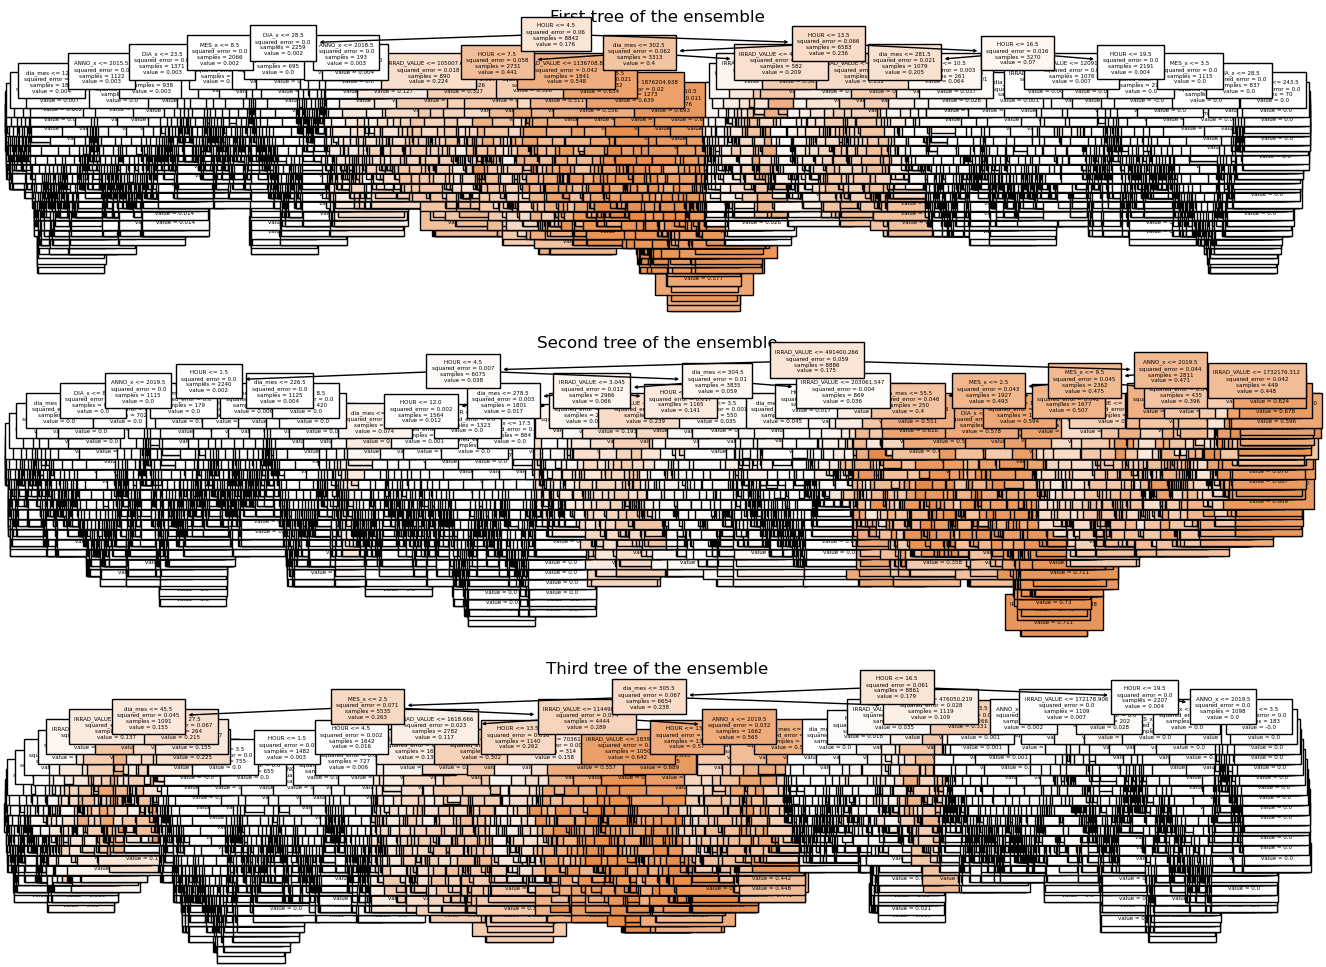

In [7]:
## Plot first trees of the ensemble
plt.figure(figsize=(16, 12))
plt.subplot(3,1,1)
plot_tree(RF_class_estim.estimators_[0], feature_names= INPUTS_RF, fontsize=4, filled=True)
plt.title(f'First tree of the ensemble')
plt.subplot(3,1,2)
plot_tree(RF_class_estim.estimators_[1], feature_names= INPUTS_RF, fontsize=4, filled=True)
plt.title(f'Second tree of the ensemble')
plt.subplot(3,1,3)
plot_tree(RF_class_estim.estimators_[2], feature_names= INPUTS_RF, fontsize=4, filled=True)
plt.title(f'Third tree of the ensemble')
plt.show()

#### 1.6.2 Importances of the inputs in the random forest

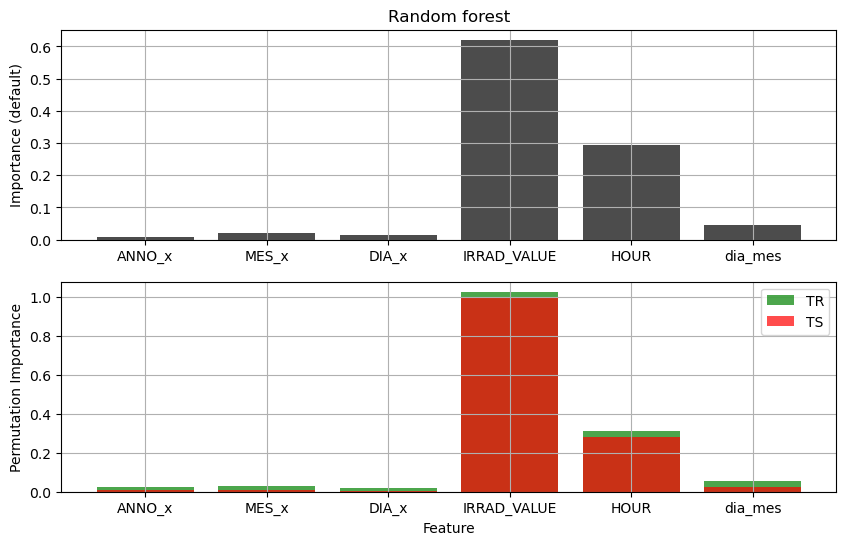

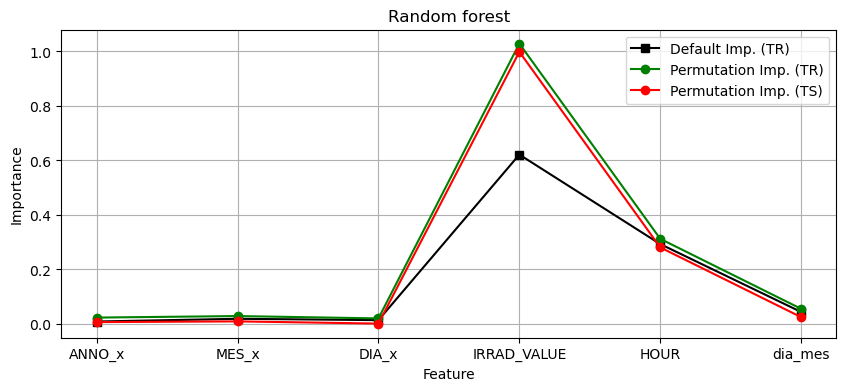

In [8]:
## Feature importance evaluation using "Permutation Importance" (training and test)
importances_tr_RF_class_estim = permutation_importance(RF_class_estim, 
                                    X_train[INPUTS_RF], y_train,
                                    n_repeats=10,
                                    random_state=0)

importances_ts_RF_class_estim = permutation_importance(RF_class_estim, 
                                    X_test[INPUTS_RF], y_test,
                                    n_repeats=10,
                                    random_state=0)
 
## Plot importances

# Plot the variable importance of each feature given by feature_importances_ attribute
plt.figure(figsize=(10, 6))

plt.subplot(2,1,1)
plt.bar(INPUTS_RF, RF_class_estim.feature_importances_, color='black', alpha=0.7)
plt.ylabel('Importance (default)')
plt.title('Random forest')
plt.grid()

plt.subplot(2,1,2)
plt.bar(INPUTS_RF, importances_tr_RF_class_estim.importances_mean, color='green', alpha=0.7, label='TR')
plt.bar(INPUTS_RF, importances_ts_RF_class_estim.importances_mean, color='red', alpha=0.7, label='TS')
plt.xlabel('Feature')
plt.ylabel('Permutation Importance')
plt.legend()
plt.grid()
plt.show()

# Plot the variable importances of each feature (all together)
plt.figure(figsize=(10, 4))

plt.plot(INPUTS_RF, RF_class_estim.feature_importances_, 's-',  color='black', label='Default Imp. (TR)')
plt.plot(INPUTS_RF, importances_tr_RF_class_estim.importances_mean, 'o-', color='green', label='Permutation Imp. (TR)')
plt.plot(INPUTS_RF, importances_ts_RF_class_estim.importances_mean, 'o-', color='red', label='Permutation Imp. (TS)')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Random forest')
plt.legend()
plt.grid()
plt.show()

#### 1.6.3 Compute errors of the forest

In [9]:
# model predictions in training (TR) and test (TS) sets
clf = RF_class_estim
y_train_pred_rf = clf.predict(X_train[INPUTS_RF]).tolist()
y_test_pred_rf = clf.predict(X_test[INPUTS_RF]).tolist()


# main metrics
mae_tr = mean_absolute_error(y_train, y_train_pred_rf)
mae_ts = mean_absolute_error(y_test, y_test_pred_rf)

mse_tr = mean_squared_error(y_train, y_train_pred_rf)
mse_ts = mean_squared_error(y_test, y_test_pred_rf)

r2_tr = r2_score(y_train, y_train_pred_rf)
r2_ts = r2_score(y_test, y_test_pred_rf)

rmse_tr = np.sqrt(mse_tr)
rmse_ts = np.sqrt(mse_ts)

# Construct DataFrame for metrics
df_metrics = pd.DataFrame([[mae_tr, mae_ts], [mse_tr, mse_ts], [r2_tr, r2_ts], [rmse_tr, rmse_ts]], 
                          index=['Mean Absolute Error', 'Mean Squared Error', 'R-squared', 'Root Mean Squared Error'], 
                          columns=['TR', 'TS'])
print(df_metrics)

                               TR        TS
Mean Absolute Error      0.017919  0.030822
Mean Squared Error       0.001226  0.003712
R-squared                0.979640  0.937205
Root Mean Squared Error  0.035018  0.060926


#### 1.6.4 Variability in the forest

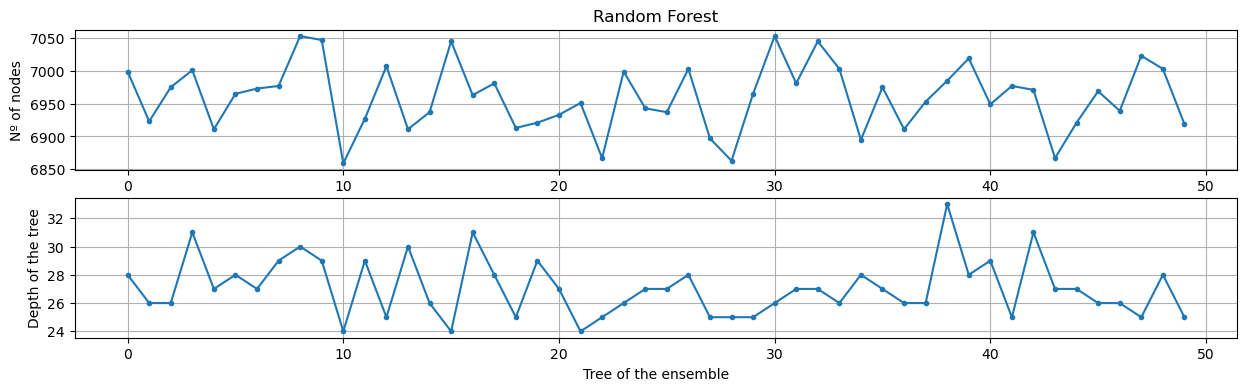

In [10]:
# number of nodes in each tree of the forest
node_count_trees_rf = [t.tree_.node_count for t in RF_class_estim.estimators_]

# number of nodes in each tree of the ensemble
depth_trees_rf = [t.tree_.max_depth for t in RF_class_estim.estimators_]

fig = plt.figure(1, figsize=(15, 4))
ax1=plt.subplot(2,1,1)
plt.plot(node_count_trees_rf, '.-')
plt.ylabel('Nº of nodes')     
plt.title('Random Forest')                  
plt.grid()

plt.subplot(2,1,2, sharex = ax1)
plt.plot(depth_trees_rf, '.-')
plt.ylabel('Depth of the tree')                       
plt.xlabel('Tree of the ensemble')                  
plt.grid()
plt.show()

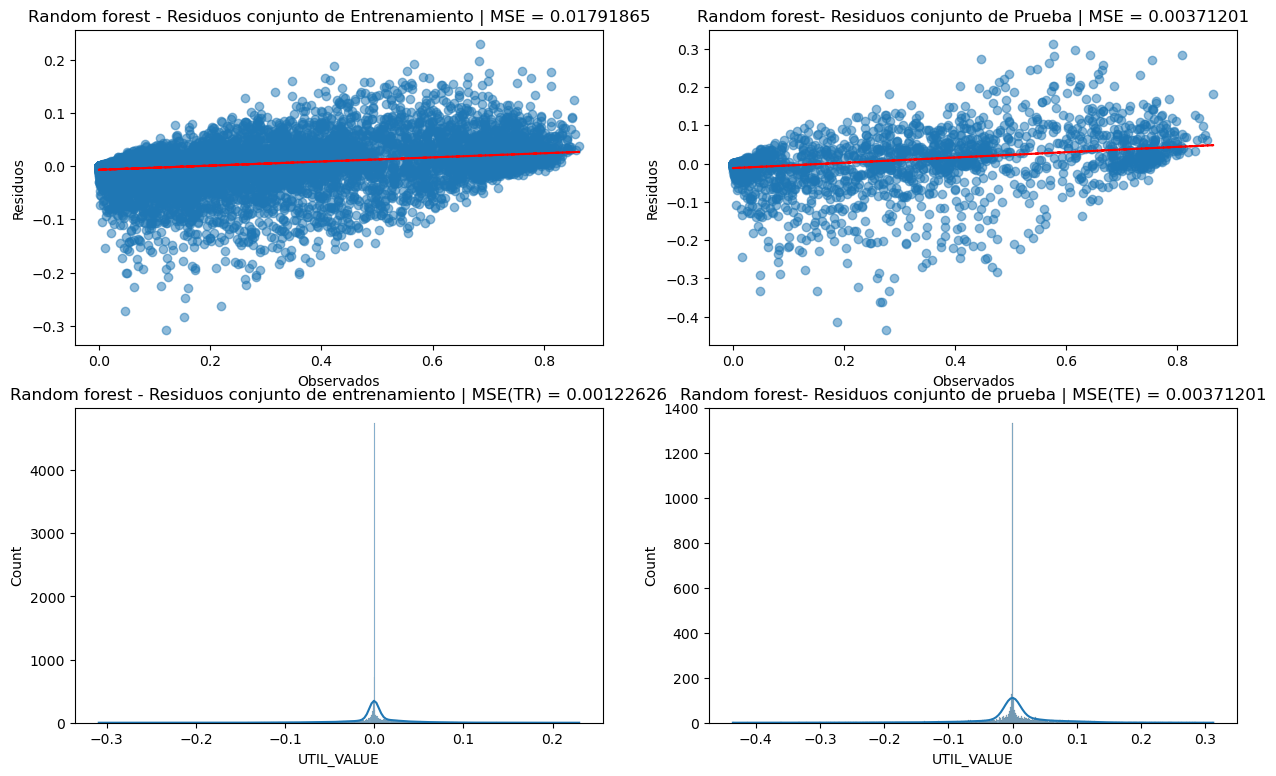

In [11]:
# Graficar los residuos (dispersión e histograma) del modelo XGBoost
plt.figure(figsize=(15, 9))

# Calcular residuos
residuals_train_bt = y_train - y_train_pred_rf
residuals_test_bt = y_test - y_test_pred_rf

# Gráficas de dispersión con línea de tendencia
for i, (y, residuals, title) in enumerate([
    (y_train, residuals_train_bt, 'Entrenamiento'),
    (y_test, residuals_test_bt, 'Prueba')
], start=1):
    plt.subplot(2, 2, i)
    plt.scatter(y, residuals, alpha=0.5)
    # Calcular línea de tendencia
    z = np.polyfit(y, residuals, 1)
    p = np.poly1d(z)
    plt.plot(y, p(y), "r--")  # Dibuja la línea de tendencia
    plt.title(f'Random forest - Residuos conjunto de {title} | MSE = {mae_tr:.8f}' if i == 1 else f'Random forest- Residuos conjunto de {title} | MSE = {mse_ts:.8f}')
    plt.xlabel('Observados')
    plt.ylabel('Residuos')

# Histogramas
plt.subplot(2, 2, 3)
sns.histplot(residuals_train_bt, kde=True)
plt.title(f'Random forest - Residuos conjunto de entrenamiento | MSE(TR) = {mse_tr:.8f}')

plt.subplot(2, 2, 4)
sns.histplot(residuals_test_bt, kde=True)
plt.title(f'Random forest- Residuos conjunto de prueba | MSE(TE) = {mse_ts:.8f}')

# Mostrar gráfica
plt.show()

### 1.7 Fit optimal Random Forest using Grid Search

In [12]:
# find optim nº of trees in the ensemble and max_features
param = {'RF__max_features': range(1, 6, 1), # Number number of features to consider when looking for the best split
         'RF__n_estimators': range(20, 150, 5)} # Number of trees in the forest

pipe =  Pipeline(steps=[('RF', 
                            RandomForestRegressor(
                                        criterion='squared_error',  # impurity measure
                                        min_samples_split=7, # Minimum number of obs in node to keep cutting
                                        min_samples_leaf=4, # Minimum number of obs in a terminal node  
                                        random_state=2024)
                        )])

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
rf_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
# fit the bagged trees
INPUTS_RF = INPUTS  
rf_fit.fit(X_train[INPUTS_RF], y_train) # Search in grid

c:\Users\pablo\anaconda3\envs\ML\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('RF',
                                        RandomForestRegressor(min_samples_leaf=4,
                                                              min_samples_split=7,
                                                              random_state=2024))]),
             n_jobs=-1,
             param_grid={'RF__max_features': range(1, 6),
                         'RF__n_estimators': range(20, 150, 5)},
             scoring='accuracy')

c:\Users\pablo\anaconda3\envs\ML\Lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


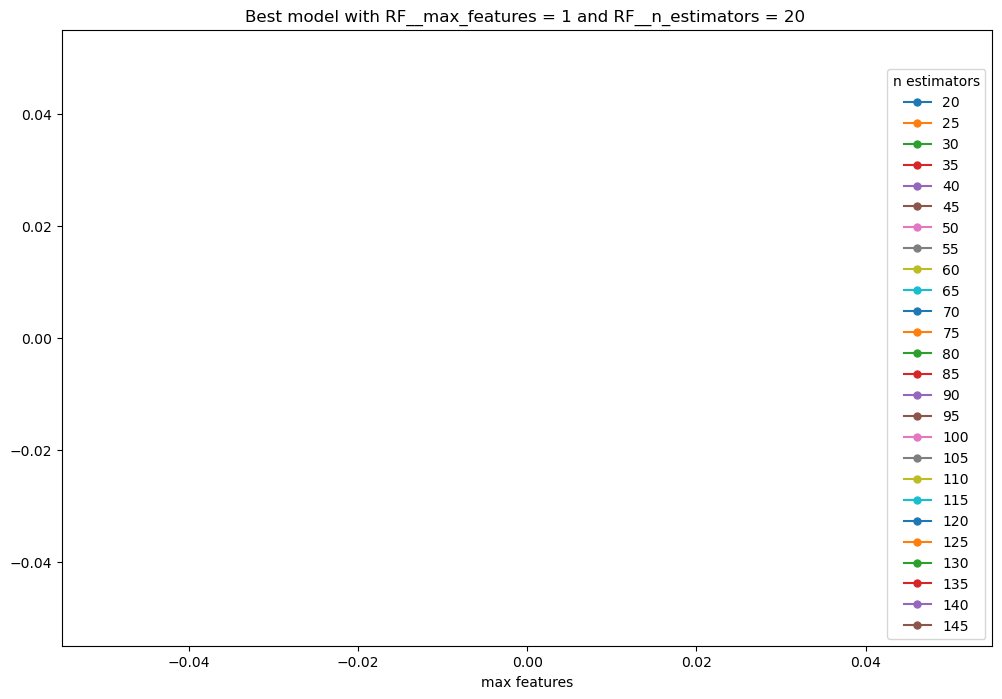

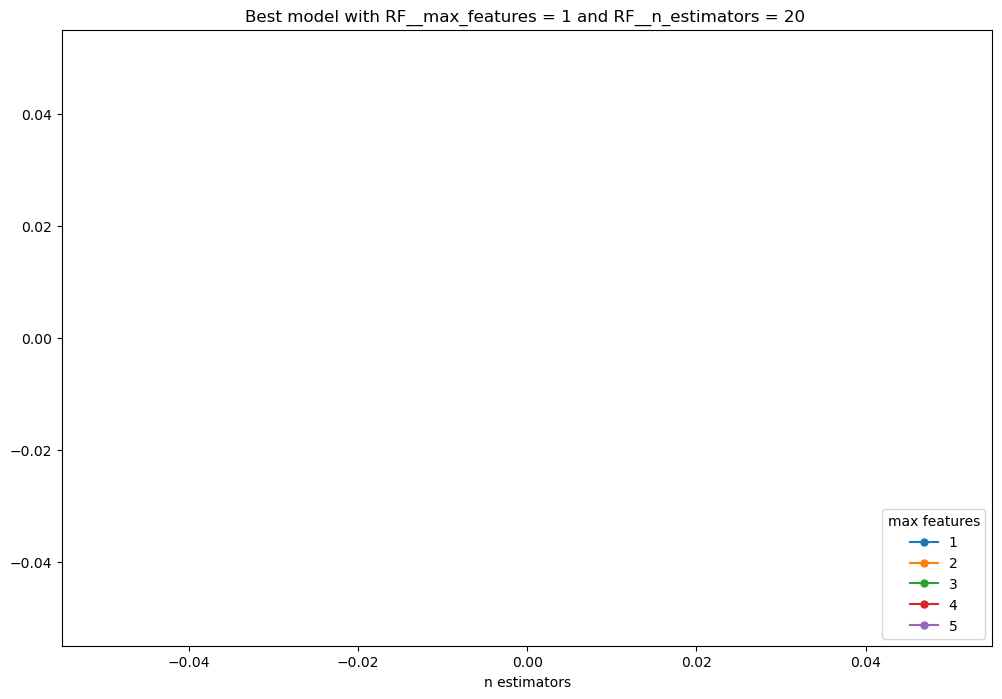

In [13]:
MT.plotModelGridError(rf_fit)

#### 1.7.1 Compute errors of the forest

In [14]:
# model predictions in training (TR) and test (TS) sets
clf = RF_class_estim
y_train_pred_rf = clf.predict(X_train[INPUTS_RF]).tolist()
y_test_pred_rf = clf.predict(X_test[INPUTS_RF]).tolist()


# main metrics
mae_tr = mean_absolute_error(y_train, y_train_pred_rf)
mae_ts = mean_absolute_error(y_test, y_test_pred_rf)

mse_tr = mean_squared_error(y_train, y_train_pred_rf)
mse_ts = mean_squared_error(y_test, y_test_pred_rf)

r2_tr = r2_score(y_train, y_train_pred_rf)
r2_ts = r2_score(y_test, y_test_pred_rf)

rmse_tr = np.sqrt(mse_tr)
rmse_ts = np.sqrt(mse_ts)

# Construct DataFrame for metrics
df_metrics = pd.DataFrame([[mae_tr, mae_ts], [mse_tr, mse_ts], [r2_tr, r2_ts], [rmse_tr, rmse_ts]], 
                          index=['Mean Absolute Error', 'Mean Squared Error', 'R-squared', 'Root Mean Squared Error'], 
                          columns=['TR', 'TS'])
print(df_metrics)

                               TR        TS
Mean Absolute Error      0.017919  0.030822
Mean Squared Error       0.001226  0.003712
R-squared                0.979640  0.937205
Root Mean Squared Error  0.035018  0.060926


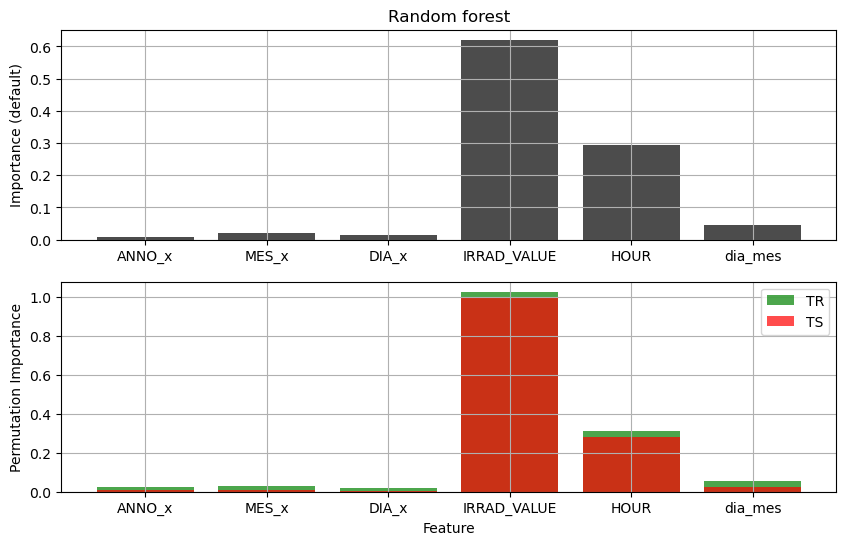

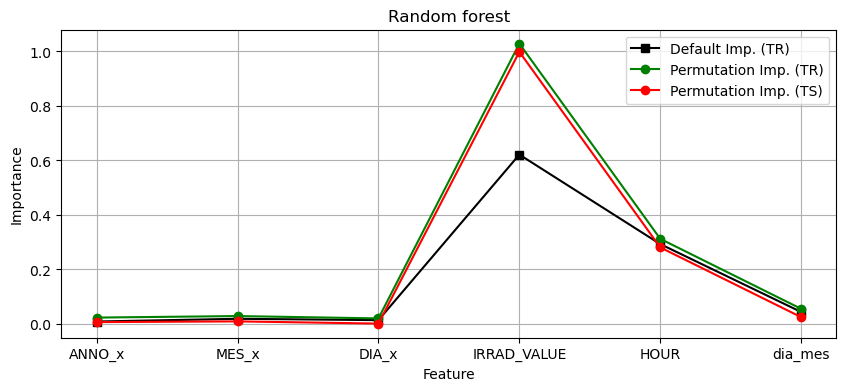

In [15]:
## Feature importance evaluation using "Permutation Importance" (training and test)
importances_tr_RF_class_estim = permutation_importance(RF_class_estim, 
                                    X_train[INPUTS_RF], y_train,
                                    n_repeats=10,
                                    random_state=0)

importances_ts_RF_class_estim = permutation_importance(RF_class_estim, 
                                    X_test[INPUTS_RF], y_test,
                                    n_repeats=10,
                                    random_state=0)
 
## Plot importances

# Plot the variable importance of each feature given by feature_importances_ attribute
plt.figure(figsize=(10, 6))

plt.subplot(2,1,1)
plt.bar(INPUTS_RF, RF_class_estim.feature_importances_, color='black', alpha=0.7)
plt.ylabel('Importance (default)')
plt.title('Random forest')
plt.grid()

plt.subplot(2,1,2)
plt.bar(INPUTS_RF, importances_tr_RF_class_estim.importances_mean, color='green', alpha=0.7, label='TR')
plt.bar(INPUTS_RF, importances_ts_RF_class_estim.importances_mean, color='red', alpha=0.7, label='TS')
plt.xlabel('Feature')
plt.ylabel('Permutation Importance')
plt.legend()
plt.grid()
plt.show()

# Plot the variable importances of each feature (all together)
plt.figure(figsize=(10, 4))

plt.plot(INPUTS_RF, RF_class_estim.feature_importances_, 's-',  color='black', label='Default Imp. (TR)')
plt.plot(INPUTS_RF, importances_tr_RF_class_estim.importances_mean, 'o-', color='green', label='Permutation Imp. (TR)')
plt.plot(INPUTS_RF, importances_ts_RF_class_estim.importances_mean, 'o-', color='red', label='Permutation Imp. (TS)')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Random forest')
plt.legend()
plt.grid()
plt.show()

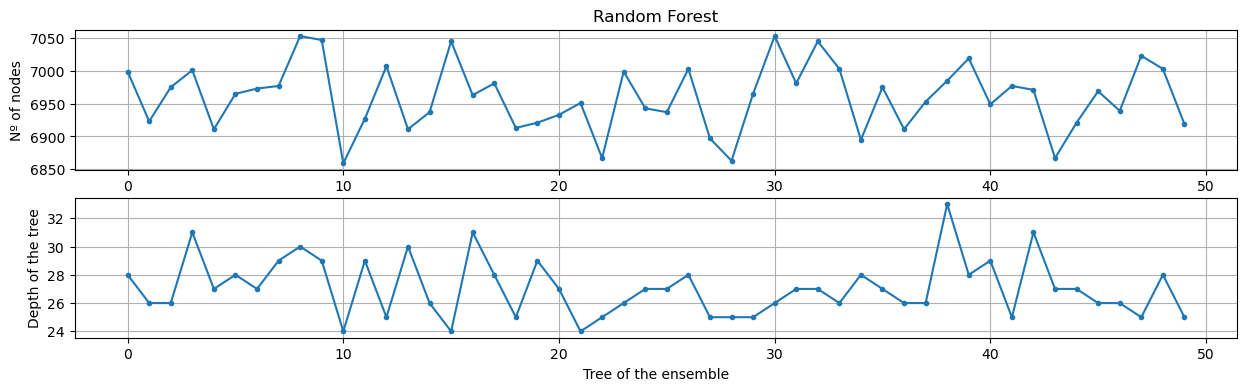

In [16]:
# number of nodes in each tree of the forest
node_count_trees_rf = [t.tree_.node_count for t in RF_class_estim.estimators_]

# number of nodes in each tree of the ensemble
depth_trees_rf = [t.tree_.max_depth for t in RF_class_estim.estimators_]

fig = plt.figure(1, figsize=(15, 4))
ax1=plt.subplot(2,1,1)
plt.plot(node_count_trees_rf, '.-')
plt.ylabel('Nº of nodes')     
plt.title('Random Forest')                  
plt.grid()

plt.subplot(2,1,2, sharex = ax1)
plt.plot(depth_trees_rf, '.-')
plt.ylabel('Depth of the tree')                       
plt.xlabel('Tree of the ensemble')                  
plt.grid()
plt.show()

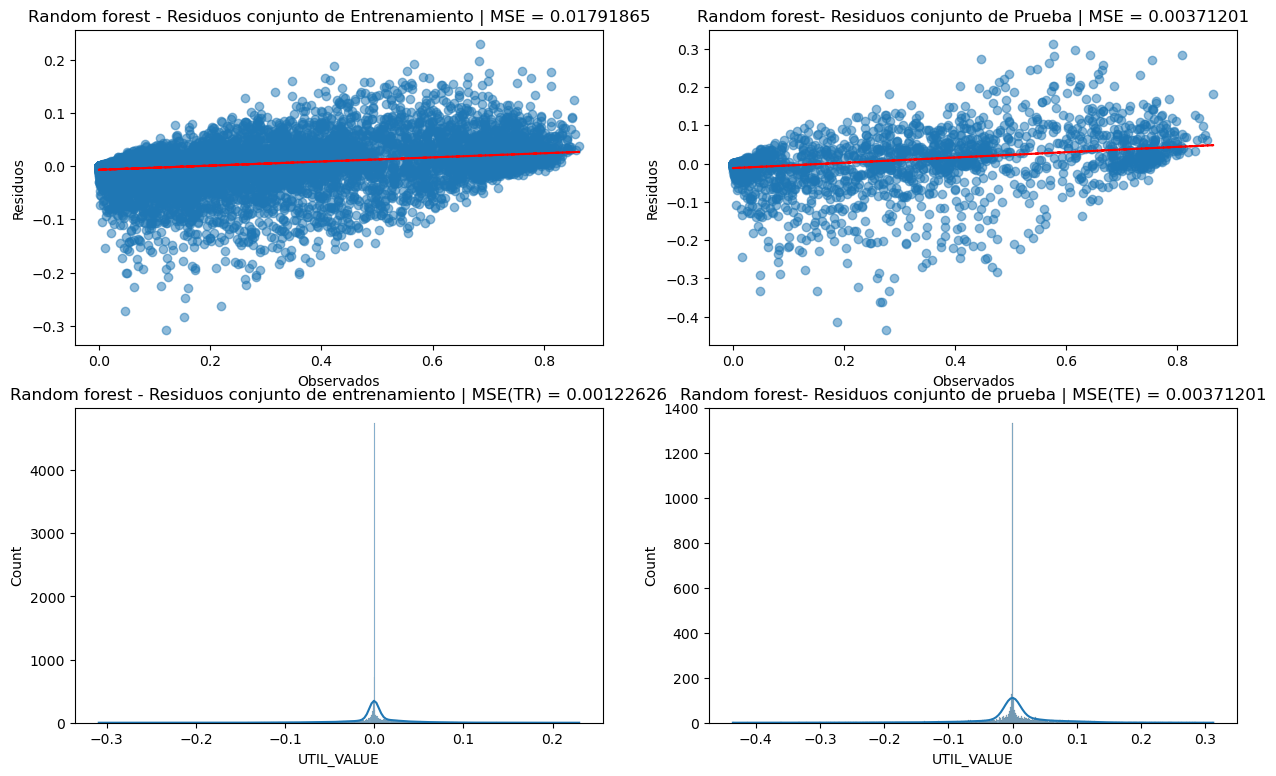

In [17]:
# Graficar los residuos (dispersión e histograma) del modelo XGBoost
plt.figure(figsize=(15, 9))

# Calcular residuos
residuals_train_bt = y_train - y_train_pred_rf
residuals_test_bt = y_test - y_test_pred_rf

# Gráficas de dispersión con línea de tendencia
for i, (y, residuals, title) in enumerate([
    (y_train, residuals_train_bt, 'Entrenamiento'),
    (y_test, residuals_test_bt, 'Prueba')
], start=1):
    plt.subplot(2, 2, i)
    plt.scatter(y, residuals, alpha=0.5)
    # Calcular línea de tendencia
    z = np.polyfit(y, residuals, 1)
    p = np.poly1d(z)
    plt.plot(y, p(y), "r--")  # Dibuja la línea de tendencia
    plt.title(f'Random forest - Residuos conjunto de {title} | MSE = {mae_tr:.8f}' if i == 1 else f'Random forest- Residuos conjunto de {title} | MSE = {mse_ts:.8f}')
    plt.xlabel('Observados')
    plt.ylabel('Residuos')

# Histogramas
plt.subplot(2, 2, 3)
sns.histplot(residuals_train_bt, kde=True)
plt.title(f'Random forest - Residuos conjunto de entrenamiento | MSE(TR) = {mse_tr:.8f}')

plt.subplot(2, 2, 4)
sns.histplot(residuals_test_bt, kde=True)
plt.title(f'Random forest- Residuos conjunto de prueba | MSE(TE) = {mse_ts:.8f}')

# Mostrar gráfica
plt.show()